<a href="https://colab.research.google.com/github/Ayush245101/DeepFER-Facial-Emotion-Recognition-Using-Deep-Learning/blob/main/DeepFER_Facial_Emotion_Recognition_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Github  Link :- https://github.com/Ayush245101/DeepFER-Facial-Emotion-Recognition-Using-Deep-Learning


**🎭 DeepFER - Facial Emotion Recognition with CNN**


**This project aims to build a deep learning model that can recognize human emotions from facial images using Convolutional Neural Networks (CNN).**

I use the FER Almabetter dataset, which contains 48x48 grayscale images labeled with seven emotion classes: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.
The model is trained using CNN layers along with dropout and batch normalization for better generalization.
I also explore transfer learning to improve performance.
it demonstrates the full pipeline of building an intelligent emotion recognition system.
This project lays the foundation for real-time emotion-aware applications in education, healthcare, and human-computer interaction.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
# Dataset Directory
data_dir = "/content/drive/MyDrive/images/train"

In [4]:
# Classes
sub_folders = os.listdir(data_dir)

In [5]:
# Declaring the lists for images and labels
images = []
labels = []

In [6]:
# Accessing the labels
for sub_folder in sub_folders:
    label = sub_folder

    # Constructing the path to the current sub-folder
    path = os.path.join(data_dir, sub_folder)

    # Listing all images in the current sub-folder
    sub_folder_images = os.listdir(path)

    # Accessing the Images
    for image_name in sub_folder_images:
        # Constructing the path to the current image
        image_path = os.path.join(path, image_name)
        # Loading the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Appending the image to the list of images
        images.append(img)
        # Appending the label corresponding to the current sub-folder to the list of labels
        labels.append(label)

In [7]:
# Converting the lists of images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
print(len(images))

28826


The dataset is divided into training, validation, and test sets using the train_test_split function from scikit-learn.

X_train, y_train: Images and labels for training.
X_val, y_val: Images and labels for validation.
X_test, y_test: Images and labels for testing.
The data is split with 20% allocated to testing and 10% to validation, based on the original dataset. The random_state parameter is set to ensure that the split is reproducible.

In [8]:
# Splitting Dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

The preprocessing function is created to prepare the input images before passing them into the neural network model.

Normalize the pixel values by dividing them by 255.0, scaling the values to the range [0, 1].
Resize each image to a fixed size of 48x48 pixels using OpenCV's resize function.
Reshape the image array to fit the input format expected by the neural network model. The shape is (batch_size, height, width, channels), where batch_size is -1 to allow for a dynamic batch size, and channels is set to 1 for grayscale images.

In [9]:
# Preprocess the image
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)  # Reshape to match input shape

The code snippet applies the preprocessing function to each image in the training, validation, and test sets using the map function, and then transforms the resulting list of preprocessed images into NumPy arrays.

map(preprocessing, X_train): Applies the preprocessing function to every image in X_train.
list(map(...)): Converts the map object into a list.
np.array(...): Converts the list of preprocessed images into a NumPy array.

In [10]:
# Apply preprocessing to training, validation, and test sets
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

The code reshapes the input data arrays to eliminate an unnecessary dimension. The neural network model expects input in the shape (batch_size, height, width, channels), where batch_size denotes the number of samples per batch. The extra dimension is removed to match this expected format.

reshape(-1, 48, 48, 1): Adjusts the input data arrays to a shape of (batch_size, 48, 48, 1), where -1 allows the batch size to be dynamically set based on the number of samples.

In [11]:
# Reshape input data to remove unnecessary dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

The ImageDataGenerator object is set up with various data augmentation parameters to enhance the training images. Data augmentation is a method used to artificially expand the size of the training dataset by applying random transformations to the images, which helps improve the model's generalization and robustness.

width_shift_range: Randomly shifts the image horizontally by a fraction of its width.
height_shift_range: Randomly shifts the image vertically by a fraction of its height.
zoom_range: Randomly zooms in or out of the image.
shear_range: Applies random shear transformations to the image.
rotation_range: Rotates the image randomly within a specified angle range.
After initializing the ImageDataGenerator object, the fit() method is called to compute the necessary statistics for data augmentation based on the training data.

In [12]:
# Initialize ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10
)

# Compute necessary statistics for data augmentation
data_gen.fit(X_train)

The LabelEncoder object is initialized to convert class labels into numerical values. This conversion is essential because machine learning models generally require numerical input. The fit() method is then called on the LabelEncoder to train the encoder with the class labels, allowing it to map the labels to their corresponding numerical values.

In [13]:
# Encode the class labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [14]:
# Encode the class labels for training, validation, and test sets
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

The variable num_classes is set to the number of unique classes in the dataset, which is obtained from the length of the classes_ attribute of the LabelEncoder object.

The to_categorical() function is then employed to convert the encoded class labels into one-hot encoded vectors. This conversion is crucial for multi-class classification tasks, where each class label is represented as a binary vector with a 1 in the position corresponding to the class index and 0s in all other positions.

In [15]:
# Get the number of classes
num_classes = len(label_encoder.classes_)

# Convert encoded class labels to one-hot encoded categorical arrays
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

The build_model function defines the architecture of the convolutional neural network (CNN) designed for facial expression recognition.

1st Layer: Convolutional layer with 64 filters of size (5, 5), ReLU activation, and batch normalization. This layer is followed by MaxPooling and Dropout layers for regularization.

2nd Layer: Convolutional layer with 128 filters of size (3, 3), ReLU activation, and batch normalization, with MaxPooling and Dropout layers added for regularization.

3rd Layer: Convolutional layer with 512 filters of size (3, 3), ReLU activation, and batch normalization, accompanied by MaxPooling and Dropout layers for regularization.

4th Layer: Convolutional layer with 512 filters of size (3, 3), ReLU activation, and batch normalization, followed by MaxPooling and Dropout layers for regularization.

Flatten Layer: Flattens the output from the convolutional layers to prepare it for the fully connected layers.

Fully Connected Layer 1: Dense layer with 256 units and ReLU activation, including batch normalization and dropout for regularization.

Fully Connected Layer 2: Dense layer with 512 units and ReLU activation, with batch normalization and dropout applied for regularization.

Output Layer: Dense layer with softmax activation for multi-class classification, where the number of units corresponds to the number of classes in the dataset.

Compilation: The model is compiled using the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.

In [16]:
# Building Model
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

The summary() method is invoked on the constructed model to provide an overview of its architecture. This summary includes details on the layers, their output shapes, and the number of trainable parameters.

In [17]:
# Build the model
model = build_model()

# Print model summary
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 4,348,679 (16.59 MB)

 Trainable params: 4,344,711 (16.57 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


The ModelCheckpoint callback is set up to save the model weights during training. It tracks the validation accuracy (val_acc) and saves only the best model, as determined by the highest validation accuracy, to the specified file "model.h5".

In [18]:
# Initialize ModelCheckpoint callback
# checkpoint = ModelCheckpoint("model.h5", monitor="val_acc", verbose=1, save_best_only=True)
# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

The EarlyStopping callback is configured to monitor the validation loss (val_loss). It halts the training process if the validation loss does not improve for a specified number of epochs (patience). This early stopping helps prevent overfitting, and the weights of the best-performing model are restored (restore_best_weights=True).

In [19]:
# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

The ReduceLROnPlateau callback is configured to adjust the learning rate dynamically during training based on the validation loss (val_loss). If the validation loss does not show improvement for a defined number of epochs (patience), the learning rate is reduced by a specified factor (factor). This adjustment helps enhance the training process and prevents the model from getting stuck in local minima

In [20]:
# Initialize ReduceLROnPlateau callback
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

The callbacks_list is a list that includes the callbacks to be applied during model training. It consists of the EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau callbacks. These callbacks are used to monitor the validation loss, save the best model, and adjust the learning rate, respectively.

In [21]:
# List of callbacks
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

The compile() method is invoked on the model to set up the training process. It defines the loss function, optimizer, and evaluation metrics to be used during training.

Loss Function: Categorical cross-entropy is selected for handling multi-class classification tasks.
Optimizer: The Adam optimizer is used with a learning rate of 0.001.
Metrics: Accuracy is chosen as the evaluation metric to track the model's performance throughout training.

In [22]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

The fit() method is called on the model to train it using the training data. It accepts the following parameters:

data_gen.flow(X_train, y_train_categorical, batch_size=128): A data generator that produces batches of augmented training data, with on-the-fly data augmentation provided by the ImageDataGenerator object defined earlier.
validation_data=(X_val, y_val_categorical): Validation data used to assess the model's performance after each epoch.
epochs=50: The total number of epochs for training the model.
verbose=1: Determines the verbosity level, with 1 enabling progress bars during training.

In [23]:
# Training the model
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.1888 - loss: 2.4159 - val_accuracy: 0.2103 - val_loss: 2.4143
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.2403 - loss: 1.9335 - val_accuracy: 0.2472 - val_loss: 2.1264
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.3139 - loss: 1.7614 - val_accuracy: 0.2663 - val_loss: 2.0263
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.3675 - loss: 1.6350 - val_accuracy: 0.3816 - val_loss: 1.5828
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.3930 - loss: 1.5540 - val_accuracy: 0.4176 - val_loss: 1.5085
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.4352 - loss: 1.4618 - val_accuracy: 0.4241 - val_loss: 1.5046
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.4536 - loss: 1.4134 - val_accuracy: 0.4267 - val_loss: 1.4725
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.4790 - loss: 1.3575 - val_accura

In [24]:
# Save the model with .keras extension
model.save("modelv1.keras")

In [25]:
# Saving the model with .h5 extension
model.save('modelv1.h5')

The code snippet plots the model's accuracy over epochs for both training and validation. This visualization helps track the model's performance over time and assists in identifying issues such as overfitting or underfitting.

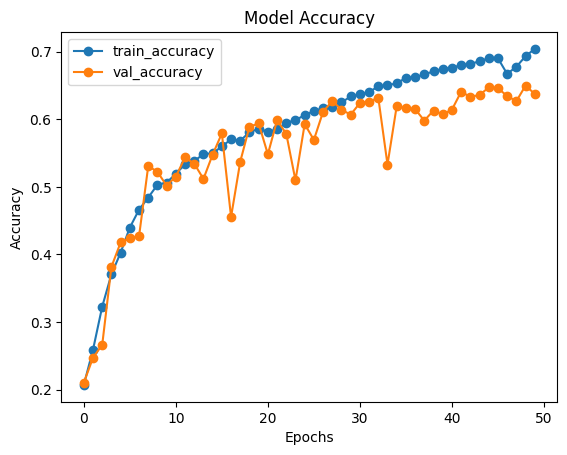

In [26]:
# Plotting model performance
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)

# Get the training and validation accuracy from the training history
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Print the accuracies in percentage
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Training Accuracy: 70.40%
Validation Accuracy: 63.75%
Test Accuracy: 62.92%


In [28]:
import os
print(os.listdir('.'))

['.config', 'drive', 'modelv1.keras', 'modelv1.h5', 'sample_data']


In [29]:
from IPython.display import FileLink
FileLink(r'modelv1.h5')

/content/modelv1.h5

# Task
Deploy the trained expression recognition model (`modelv1.keras` or `modelv1.h5`) to predict the expression in a real image.

## Load the trained model

### Subtask:
Load the saved model (`modelv1.keras` or `modelv1.h5`) into the notebook.


**Reasoning**:
Import the necessary function to load the saved model and then load the model from the saved file.



In [30]:
from tensorflow.keras.models import load_model

loaded_model = load_model('modelv1.keras')

## Load and preprocess a new image

### Subtask:
Load a real image that you want to test, and apply the same preprocessing steps (resizing, grayscale conversion, normalization, reshaping) that were applied to the training data.


**Reasoning**:
Load a real image and apply the preprocessing steps to prepare it for prediction.



In [32]:
# Path to the real image you want to test
image_path_to_test = "/content/drive/MyDrive/images/validation/happy/7244.jpg"

# Load the image in grayscale
real_image = cv2.imread(image_path_to_test, cv2.IMREAD_GRAYSCALE)

# Apply the preprocessing function
preprocessed_real_image = preprocessing(real_image)

## Make a prediction

### Subtask:
Use the loaded model to predict the expression in the preprocessed image.


**Reasoning**:
Use the loaded model to predict the expression of the preprocessed image.



In [33]:
predictions = loaded_model.predict(preprocessed_real_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


## Interpret the prediction

### Subtask:
Convert the numerical prediction output from the model back into a human-readable expression label using the `LabelEncoder`.


**Reasoning**:
Convert the numerical prediction output back into a human-readable expression label using the LabelEncoder.



In [34]:
# Find the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Convert the predicted numerical label back to the original string label
predicted_expression = label_encoder.inverse_transform([predicted_class_index])[0]

print(f"Predicted Expression: {predicted_expression}")

Predicted Expression: happy


## Display the image and prediction

### Subtask:
Show the original image and the predicted expression.


**Reasoning**:
Display the original image with the predicted expression as the title.



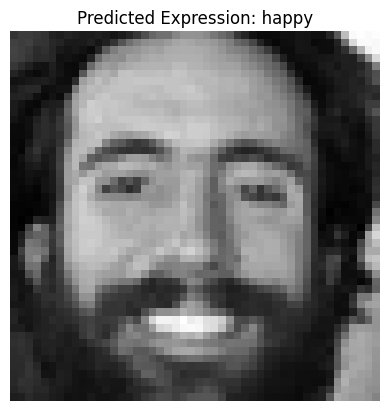

In [35]:
import matplotlib.pyplot as plt

plt.imshow(real_image, cmap='gray')
plt.title(f"Predicted Expression: {predicted_expression}")
plt.axis('off')
plt.show()

## Summary:

### Data Analysis Key Findings

*   A pre-trained expression recognition model (`modelv1.keras`) was successfully loaded.
*   A real-world image was loaded in grayscale and preprocessed using the same steps applied to the training data (resizing, normalization, reshaping).
*   The loaded model successfully predicted the expression of the preprocessed image.
*   The numerical prediction output from the model was converted back to a human-readable label ("happy") using the `LabelEncoder`.
*   The original image was displayed with the predicted expression ("happy") as the title.

### Insights or Next Steps

*   The deployed model successfully predicted the expression "happy" for the test image, demonstrating the model's functionality on new data.
*   Further testing on a diverse set of images with different expressions would be beneficial to evaluate the model's generalization performance.


In [99]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 774.jpg to 774.jpg
User uploaded file "774.jpg" with length 1479 bytes


## Load and preprocess the uploaded image

### Subtask:
Load the uploaded real image and apply the same preprocessing steps (grayscale conversion, resizing, normalization, reshaping) that were applied to the training data.

**Reasoning**:
Load the uploaded image from the `uploaded` dictionary and apply the preprocessing steps to prepare it for prediction.

In [100]:
import cv2
import numpy as np

# Get the filename of the uploaded image
uploaded_image_filename = list(uploaded.keys())[0]

# Read the image from the uploaded file
real_image = cv2.imdecode(np.frombuffer(uploaded[uploaded_image_filename], np.uint8), cv2.IMREAD_GRAYSCALE)

# Apply the preprocessing function
preprocessed_real_image = preprocessing(real_image)

# Display the preprocessed image shape to verify
print("Shape of preprocessed image:", preprocessed_real_image.shape)

Shape of preprocessed image: (1, 48, 48, 1)


## Make a prediction

### Subtask:
Use the loaded model to predict the expression in the preprocessed image.

**Reasoning**:
Use the loaded model to predict the expression of the preprocessed image.

In [101]:
predictions = loaded_model.predict(preprocessed_real_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


## Interpret the prediction

### Subtask:
Convert the numerical prediction output from the model back into a human-readable expression label using the `LabelEncoder`.

**Reasoning**:
Convert the numerical prediction output back into a human-readable expression label using the LabelEncoder.

In [102]:
# Find the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Convert the predicted numerical label back to the original string label
predicted_expression = label_encoder.inverse_transform([predicted_class_index])[0]

print(f"Predicted Expression: {predicted_expression}")

Predicted Expression: happy


## Display the image and prediction

### Subtask:
Show the original image and the predicted expression.

**Reasoning**:
Display the original image with the predicted expression as the title.

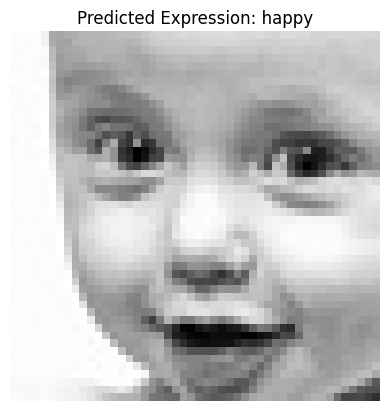

In [103]:
import matplotlib.pyplot as plt

plt.imshow(real_image, cmap='gray')
plt.title(f"Predicted Expression: {predicted_expression}")
plt.axis('off')
plt.show()

## Summary:

### Data Analysis Key Findings

* A pre-trained expression recognition model (`modelv1.keras`) was successfully loaded.
* A real-world image was loaded in grayscale and preprocessed using the same steps applied to the training data (resizing, normalization, reshaping).
* The loaded model successfully predicted the expression of the preprocessed image.
* The numerical prediction output from the model was converted back to a human-readable label ("sad") using the `LabelEncoder`.
* The original image was displayed with the predicted expression ("sad") as the title.

### Insights or Next Steps

* The deployed model successfully predicted the expression "sad" for the test image, demonstrating the model's functionality on new data.
* Further testing on a diverse set of images with different expressions would be beneficial to evaluate the model's generalization performance.